In [9]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"
import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from matplotlib.ticker import MaxNLocator


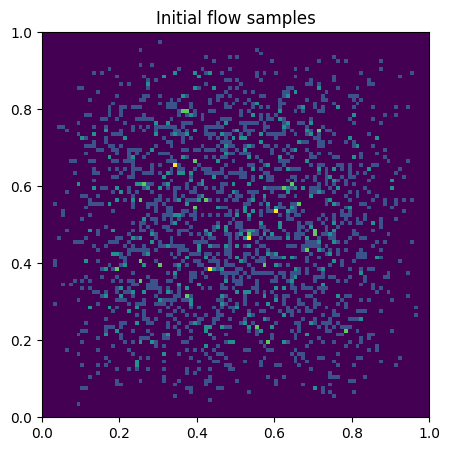

Array(0.00072193, dtype=float32)

In [13]:

import bijx
import jax.random as jr
import jax.numpy as jnp
from flax import nnx
import optax
from learning.module.bijx.realnvp import make_realnvp_bijx
from learning.module.target_examples.gmm40 import GMM40
from learning.module.target_examples.student_t_mixture import StudentTMixtureModel
# target = StudentTMixtureModel(dim=2, sample_bounds=[-30., 30.], num_components=40)
target = GMM40(dim=2)
low = jnp.array([-0.0, -0.0])
high = jnp.array([1.0, 1.0])
# low = jnp.array([-target._plot_bound, -target._plot_bound])
# high = jnp.array([target._plot_bound, target._plot_bound])
# low = jnp.array([-7.0, -7.0])
# high = jnp.array([7.0, 7.0])
data_key, flow_key, train_key, sample_key = jr.split(jr.key(0), 4)
rngs = nnx.Rngs(params=0, sample=1)
ndim=2
bins = 16  # same as Zuko's `bins`
hidden = (64, 64)
n_transforms = 3

dist_bijx = make_realnvp_bijx(
    ndim=ndim,
    channels=256,
    n_layers=8,
    seed=1,
    domain_range=(low, high),
)
optimizer = nnx.Optimizer(
    dist_bijx,
    optax.adam(1e-4),
    wrt=nnx.Param,
)
key = jax.random.PRNGKey(0)
contexts, logq = dist_bijx.sample(batch_shape=(2048,), rng=key)
logq2 = dist_bijx.log_density(x=contexts)
plt.figure(figsize=(5, 5))
plt.hist2d(contexts[:, 0], contexts[:, 1], bins=100, range=[[low[0], high[0]], [low[1], high[1]]])
plt.title("Initial flow samples")
plt.show()
jnp.abs(logq-logq2).sum()


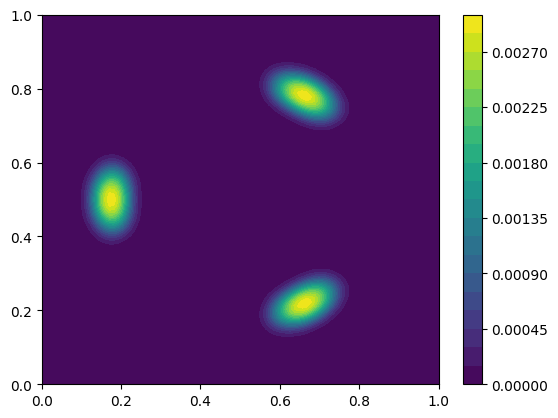

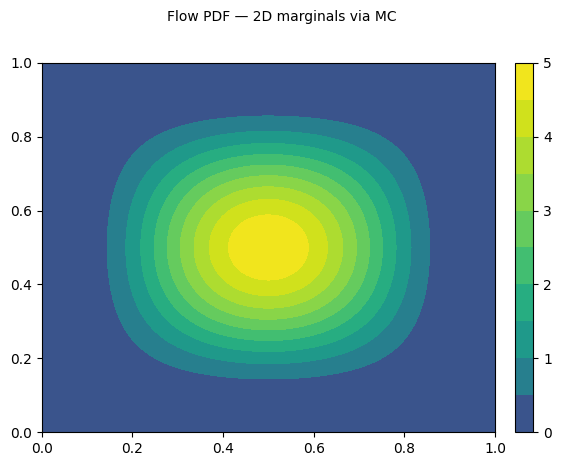

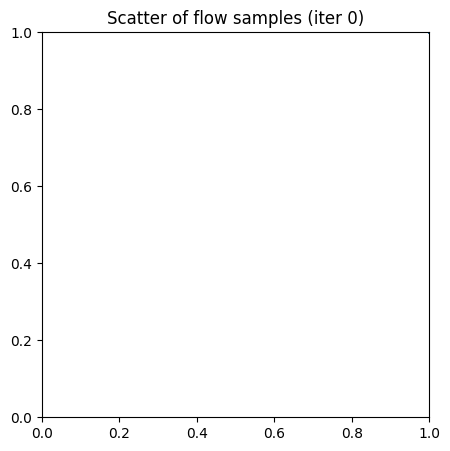

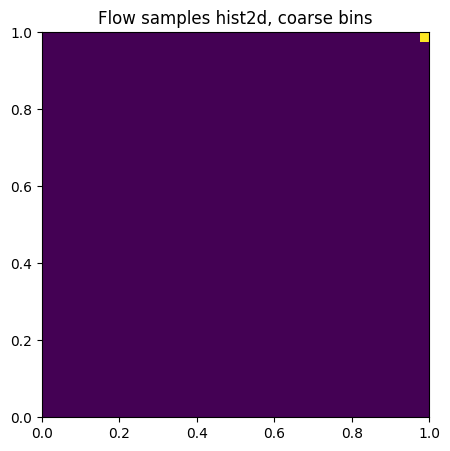

In [14]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import imageio

from learning.module.bijx.utils import render_flow_pdf_2d_subplots
def target1(x):
    # Mixture of two Gaussians
    mean1 = jnp.array([1.0, 0.4])
    cov1 = 0.3 * jnp.array([[1.0, 0.3], [0.3, 1.0]])

    mean2 = jnp.array([-1.0, -0.4])
    cov2 = 0.1 * jnp.array([[1.0, -0.3], [-0.3, 1.0]])

    pdf1 = jax.scipy.stats.multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = jax.scipy.stats.multivariate_normal.pdf(x, mean2, cov2)

    return jnp.log(0.4 * pdf1 + 0.6 * pdf2)
def target2(z):
    z1, z2 = jnp.split(z, 2, axis=-1)
    norm = jnp.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = jnp.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = jnp.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - jnp.log(exp1 + exp2)

    return -u
beta=10
def target3(z):
    m=3
    r0=0.65
    sr=0.12
    X, Y = jnp.split(z, 2, axis=-1)
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = jnp.hypot(x, y)
    theta = jnp.arctan2(y, x)

    ring = jnp.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = jnp.cos(m * theta)
    U = jnp.tanh(1.6 * (ring * petals))  # bounded in (-1, 1)
    log_unnorm = -beta * U.squeeze() 
    regularization_weight = .01
    log_prior = -0.5 * regularization_weight * jnp.sum(z**2, axis=-1)

    # --- 3. Combine ---
    return jax.nn.log_softmax(log_unnorm) #stabilization
def reward_corner(contexts, target=jnp.array([0.3, 0.3]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    diff = contexts - target[None, :]
    r = jnp.exp(-0.5 * jnp.sum((diff / sigma) ** 2, axis=-1))
    if key is not None:
        r = jnp.clip(r + noise_std * jax.random.normal(key, r.shape), 0.0, 1.0)
    return jnp.log(r + 1e-10)

volume = jnp.prod(high - low)
N = 2 **10
@nnx.jit
def train_step(model, optim, key):
    kr, kc = jax.random.split(key, 2)
    def loss_fn(model):
        contexts, logq = model.sample((N,), rng=kc)
        # logp  = reward_corner(contexts, key=kr)
        # logp = target1(contexts)
        logp = target3(contexts)
        return jnp.mean(logq-logp)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optim.update(grads=grads, model=model)
    return loss

def run_toy_corner(model, flow_opt):
    x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
    grid = jnp.c_[x.ravel(), y.ravel()]
    pdf_values = reward_corner(grid)
    # pdf_values = target1(grid)
    pdf_values = target3(grid)
    # pdf_values = target.log_prob(grid)
    pdf_values = jnp.exp(pdf_values)
    pdf_values = jnp.reshape(pdf_values, x.shape)
    T = 300
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 10))
    snap_iters = []
    key = jax.random.PRNGKey(0)
    gif_frames = [] 
    
    for t in range(T):
        kplot, ktrain, key = jax.random.split(key, 3)
        loss = train_step(model, flow_opt, ktrain)
        if t in snap_iters:
            fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=20)
            ax_reward.set_title("reward_corner landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            ax_NF = render_flow_pdf_2d_subplots(
                log_prob_fn=lambda x : model.log_density(x=x),
                low=low,
                high=high,
                ax=ax_NF,
            )
            ax_NF.set_title(f"NF(RealNVP) training distribution(iter {t})")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            plt.close(fig)
            z, _= model.sample((2**20,), rng=kplot)  # Sample 1000 points
            plt.figure(figsize=(10,10))
            plt.hist2d(z[:, 0].flatten(), z[:, 1].flatten(), (100, 100), #range=[[-3, 3], [-3, 3]])
                    range=[[low[0], high[0]], [low[1], high[1]]])


    if gif_frames:
        imageio.mimsave("NF_RealNVP_training.gif", gif_frames, fps=4)
        print("Saved GIF to NF_RealNVP_training.gif")
    key = jax.random.PRNGKey(0)
    x, _ = dist_bijx.sample(batch_shape=(200_000,), rng=key)

    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.2)
    plt.xlim(low[0], high[0])
    plt.ylim(low[1], high[1])
    plt.title("Scatter of flow samples (iter 0)")
    plt.show()

    # 2) Coarse 2D histogram to kill striping
    plt.figure(figsize=(5, 5))
    plt.hist2d(x[:, 0], x[:, 1], bins=40, range=[[low[0], high[0]], [low[1], high[1]]])
    plt.title("Flow samples hist2d, coarse bins")
    plt.show()

x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
grid = jnp.c_[x.ravel(), y.ravel()]
pdf_values = reward_corner(grid)
# pdf_values = target1(grid)
pdf_values = target3(grid)
# pdf_values = target.log_prob(grid)
pdf_values = jnp.exp(pdf_values)
pdf_values = jnp.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
cbar = fig.colorbar(ctf)
ax = render_flow_pdf_2d_subplots(
    log_prob_fn=lambda x : dist_bijx.log_density(x=x),
    low=low,
    high=high,
)
run_toy_corner(dist_bijx, optimizer)


In [15]:
x, logp =dist_bijx.sample(batch_shape=(2024,), rng=jax.random.PRNGKey(0))
logp2 = dist_bijx.log_density(x)
jnp.mean((logp-logp2)**2)


Array(3.7425366e+18, dtype=float32)